In [23]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
titanic = pd.read_csv('./Titanic.csv')

# Display the first few rows of the dataframe
titanic.head()

,Unnamed: 0,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1st,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.337494,B5,Southampton,2,NaN,"St Louis, MO"
1,2,1st,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.550003,C22 C26,Southampton,11,NaN,"Montreal, PQ / Chesterville, ON"
2,3,1st,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,4,1st,0,"Allison, Mr. Hudson Joshua Crei",male,30.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,5,1st,0,"Allison, Mrs. Hudson J C (Bessi",female,25.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,NaN,"Montreal, PQ / Chesterville, ON"


# Step 1

In [24]:
def QuantileBinning(feature, bin_number):
    """
    This function takes a numerical feature and the number of bins, and
    returns the feature binned into quantile-based bins.

    Parameters:
    - feature (pandas.Series): The numerical feature to be binned.
    - bin_number (int): The number of quantile bins.

    Returns:
    - pandas.Series: A series of discrete features binned by quantile.
    """
    # Use qcut to create quantile-based bins for the feature
    # If there are fewer unique values than bins, qcut could throw an error.
    # 'duplicates' parameter handles this by dropping redundant bins.
    return pd.qcut(feature, q=bin_number, labels=False, duplicates='drop')

# One example
feature_test = pd.DataFrame(np.random.rand(100),  columns=['Column_A'])
feature_test_discrete = QuantileBinning(feature_test['Column_A'], 10)

def label_encoder(feature):
    unique_labels = pd.unique(feature)
    label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
    transformed_feature = np.array([label_to_int[label] for label in feature])
    return transformed_feature

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

In [26]:
# Fill missing values in 'age' with the average age
titanic['age'].fillna(titanic['age'].mean(), inplace=True)

selected_features = ['pclass', 'sex', 'age', 'sibsp', 'survived']
titanic_subset = titanic[selected_features].copy()

titanic_subset['survived'] = titanic_subset['survived'].astype(int)


# Discretization
titanic_subset['age_discrete'] = QuantileBinning(titanic_subset['age'], 5)
titanic_subset['sibsp_discrete'] = QuantileBinning(titanic_subset['sibsp'], 3)

titanic_subset['sex_encoded'] = label_encoder(titanic_subset['sex'])
titanic_subset['pclass_encoded'] = label_encoder(titanic_subset['pclass'])

feature_columns = ['pclass_encoded', 'sex_encoded', 'age_discrete', 'sibsp_discrete']
X = titanic_subset[feature_columns]
y = titanic_subset['survived']


# Split the data into 80% training and 20% test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

training = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

C:\Users\ahmad\AppData\Local\Temp\ipykernel_7620\223673864.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic['age'].fillna(titanic['age'].mean(), inplace=True)


In [27]:
training.head()

,pclass_encoded,sex_encoded,age_discrete,sibsp_discrete,survived
772,2,1,0,0,0
543,1,1,3,0,0
289,0,0,0,0,1
10,0,1,4,0,0
147,0,1,2,0,0


# Step 2

In [28]:
# define your entropy function and information gain function
def entropy(y):
    values, counts = np.unique(y, return_counts=True)
    probs = counts / counts.sum()
    return -np.sum(probs * np.log2(probs + 1e-9)) 

def information_gain(feature, target):
    total_entr = entropy(target)
    vals, counts = np.unique(feature, return_counts=True)
    weighted_entr = np.sum([
        (counts[i] / np.sum(counts)) * entropy(target[feature == vals[i]])
        for i in range(len(vals))
    ])
    return total_entr - weighted_entr

# Calculate Information Gain for each feature in the training set
info_gains = {}
for col in feature_columns:
    result = information_gain(training[col].values, training['survived'].values)
    info_gains[col] = result

print(info_gains)

best = max(info_gains, key=info_gains.get)
print(f"Best attribute to split: {best}")

{'pclass_encoded': np.float64(0.06353574221838043), 'sex_encoded': np.float64(0.20968297666244162), 'age_discrete': np.float64(0.008131527193327326), 'sibsp_discrete': np.float64(0.0)}
Best attribute to split: sex_encoded


In [29]:
info_gains

{'pclass_encoded': np.float64(0.06353574221838043),
 'sex_encoded': np.float64(0.20968297666244162),
 'age_discrete': np.float64(0.008131527193327326),
 'sibsp_discrete': np.float64(0.0)}

So the first split should be "sex"

# Step 3

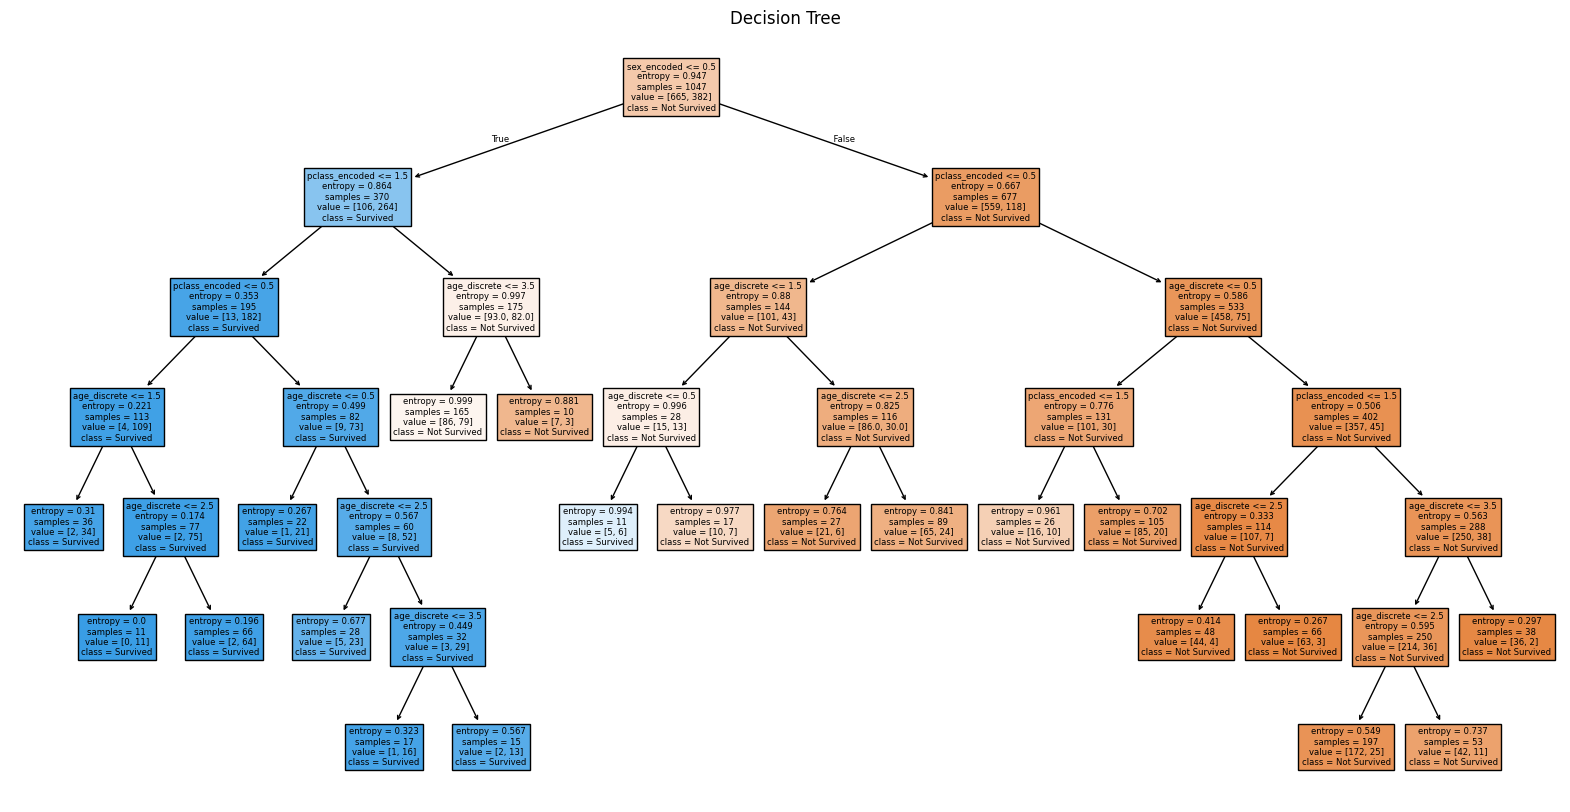

In [30]:
from sklearn.tree import DecisionTreeClassifier, plot_tree #sklearn.metrics is not imported !!!
import matplotlib.pyplot as plt

# Instantiate the DecisionTreeClassifier
student_id = 20006460
dt_model = DecisionTreeClassifier(criterion="entropy", max_leaf_nodes=20, random_state=student_id)

# Prepare the features and target variables for training
X_train_values = X_train.values
y_train_values = y_train.values
X_test_values = X_test.values
y_test_values = y_test.values


# Fit the decision tree model
dt_model.fit(X_train_values, y_train_values)


# Plot the full decision tree
plt.figure(figsize=(20, 10))
plot_tree(dt_model, feature_names=feature_columns, class_names=["Not Survived", "Survived"], filled=True)
plt.title("Decision Tree")
plt.show()


In [ ]:
# Define your performance metrics including accuracy, precision, recall and F1-scorre
def eval(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))

    accuracy = (TP + TN) / len(y_true)
    precision = TP / (TP + FP + 1e-9)
    recall = TP / (TP + FN + 1e-9)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-9)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

y_pred_test = dt_model.predict(X_test_values)
eval(y_test_values, y_pred_test)

Accuracy: 0.7328
Precision: 0.9286
Recall: 0.4407
F1 Score: 0.5977


# Step 4

Optimal max leaf nodes: 5


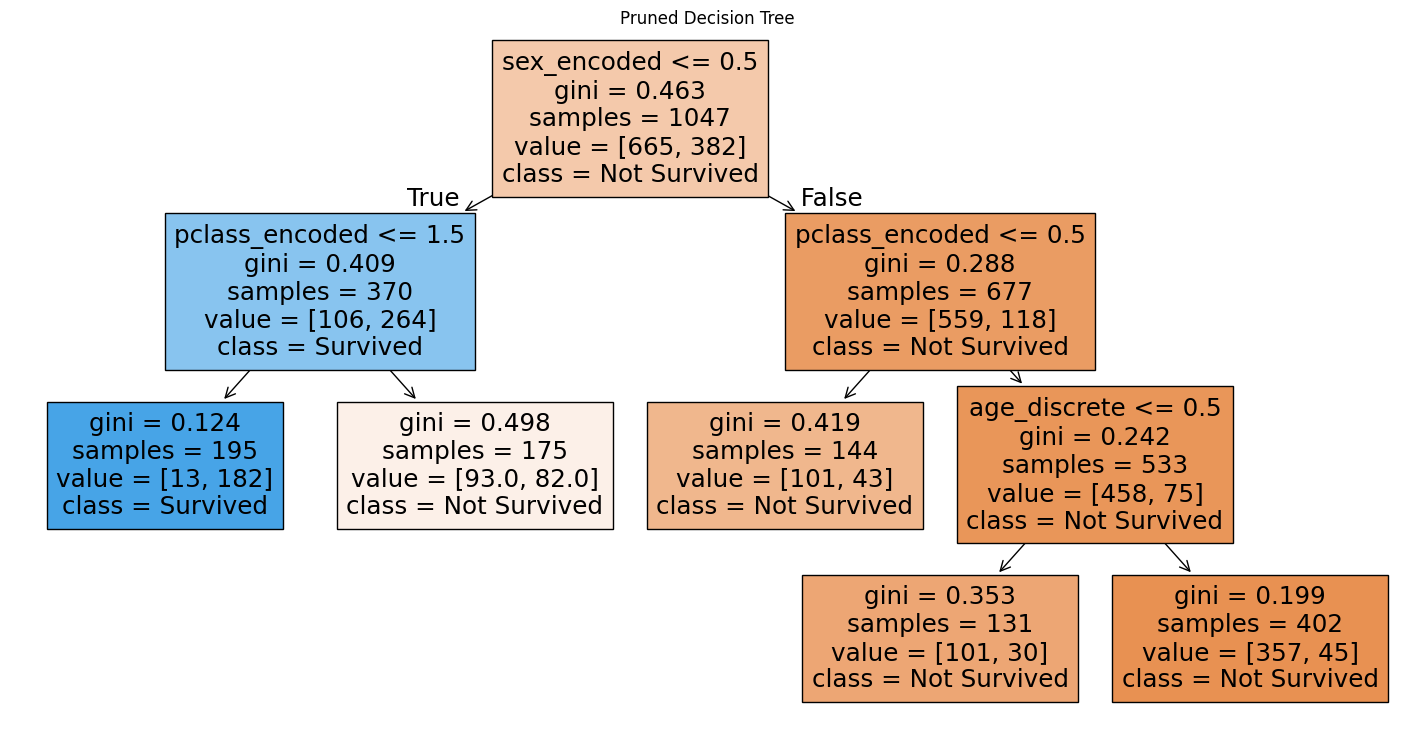

Accuracy: 0.7290
Precision: 0.9273
Recall: 0.4322
F1 Score: 0.5896


In [32]:
from sklearn.model_selection import GridSearchCV

# Define a range of max_leaf_nodes values to search
param_grid = {'max_leaf_nodes': list(range(5, 20))}

# Run grid search with cross-validation
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train) # Note testing set cannot be used

# Get the best estimator with the optimal max_leaf_nodes parameter
best_tree = grid_search.best_estimator_
best_leaf_nodes = grid_search.best_params_['max_leaf_nodes']
print(f"Optimal max leaf nodes: {best_leaf_nodes}")

# Plot the pruned decision tree
plt.figure(figsize=(18, 9))
plot_tree(best_tree, feature_names=feature_columns, class_names=['Not Survived', 'Survived'], filled=True)
plt.title(f"Pruned Decision Tree")
plt.show()

y_pred_pruned = best_tree.predict(X_test)
eval(y_test.values, y_pred_pruned)


# Step 5


In [33]:
## it's an example (max_depth)

Accuracy: 0.7290
Precision: 0.9273
Recall: 0.4322
F1 Score: 0.5896


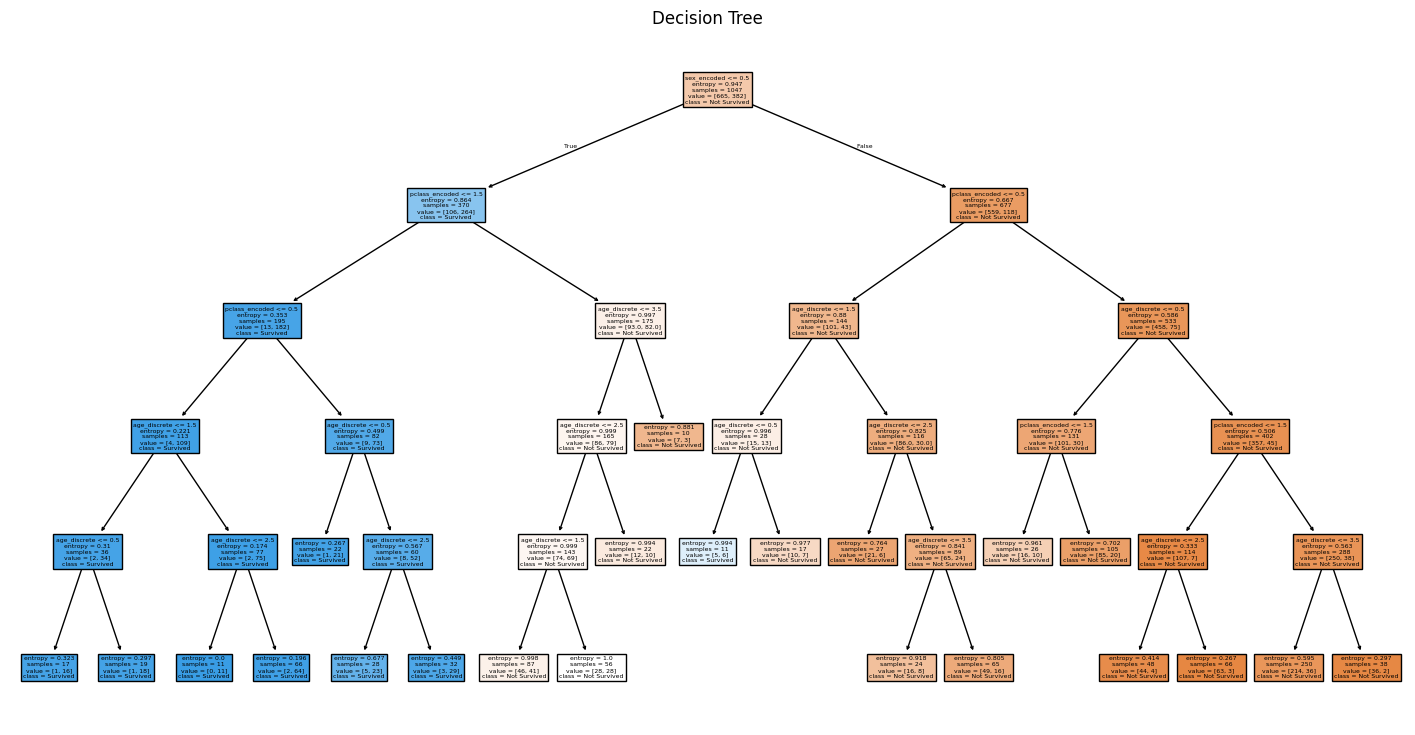

In [34]:
from sklearn.ensemble import RandomForestClassifier

def ensemble_vote(models, X):

    # Perform majority vote
    # For each sample, count the votes for each class (0 or 1)
    predictions = np.array([m.predict(X) for m in models]) 
    votes = np.sum(predictions, axis=0)  

    # Determine the winning class for each sample: it's the one with the most votes
    # If there's a tie, we choose the class with the highest index (1 in this case)
    ensemble_predictions = np.where(votes >= len(models)/2, 1, 0)  

    return ensemble_predictions

dt_max_depth = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=5,  
    random_state=student_id
)
dt_max_depth.fit(X_train, y_train)

dt_opt_critia = DecisionTreeClassifier(
    criterion='gini',  
    max_leaf_nodes=best_leaf_nodes,
    random_state=student_id
)
dt_opt_critia.fit(X_train, y_train)

# Use the defined function to get predictions from the ensemble of the three trees
models = [best_tree, dt_max_depth, dt_opt_critia]
ensemble_predictions = ensemble_vote(models, X_test)

# Calculate performance metrics for the ensemble using the previously defined function
eval(y_test.values, ensemble_predictions)


plt.figure(figsize=(18, 9))
plot_tree(dt_max_depth, 
          feature_names=feature_columns, 
          class_names=['Not Survived', 'Survived'],
          filled=True)
plt.title("Decision Tree")
plt.show()

In [35]:
# Train a random forest model using the optimal tree you found in step 4 and compare the ensembled model with the random forest 
rf_model = RandomForestClassifier(
    criterion='entropy',           
    max_leaf_nodes=best_leaf_nodes,  
    n_estimators=50,
    random_state=student_id
)
rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)
eval(y_test.values, rf_pred)

Accuracy: 0.7290
Precision: 0.9273
Recall: 0.4322
F1 Score: 0.5896
